In [ ]:
# ==== Paths & parameters ====
from pathlib import Path

XDF_PATH = Path("../data/sub-P001_ses-S001_task-Default_run-001_eeg.xdf")  # <— set your file
OUTDIR   = Path("../results/data7eeg_out_nb")
OUTDIR.mkdir(parents=True, exist_ok=True)

# plotting
PLOT_UV = 500.0   # vertical scale per channel (µV) for raw plots
TRIAL_PRE  = 0.5  # seconds before trial onset to show
TRIAL_POST = 1.5  # seconds after trial onset to show

# filtering
MAINS = 50        # 50 in EU, 60 in US
BANDPASS = (1.0, 40.0)  # Hz (keeps theta/alpha/beta for workload)
RUN_ICA = False   # set True only if you need ICA now (optional)


In [19]:
# ==== Imports & helpers ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import pyxdf
import re
from typing import Optional, List, Tuple
from mne.time_frequency import psd_array_welch

# Make Matplotlib non-interactive-save friendly
%matplotlib inline

def load_xdf_safe(path: Path):
    """Robust XDF loader with fallbacks."""
    try:
        streams, header = pyxdf.load_xdf(
            str(path),
            synchronize_clocks=True,
            dejitter_timestamps=True,
            handle_clock_resets=True,
        )
    except Exception as e:
        print("[WARN] Full load failed:", e)
        streams, header = pyxdf.load_xdf(
            str(path),
            synchronize_clocks=False,
            dejitter_timestamps=False,
            handle_clock_resets=False,
        )
    return streams, header

def _safe_get(d, key, default):
    try:
        v = d.get(key, default)
        if isinstance(v, (list, tuple)) and len(v) == 1:
            return v[0]
        return v
    except Exception:
        return default

def pick_streams(streams) -> Tuple[dict, Optional[dict]]:
    """Pick EEG stream + marker stream."""
    eeg_stream, marker_stream = None, None
    for st in streams:
        info = st.get("info", {})
        stype = str(_safe_get(info, "type", "")).lower()
        sname = str(_safe_get(info, "name", "")).lower()
        ch_n  = int(float(_safe_get(info, "channel_count", "0")))
        if ("eeg" in stype or "unicorn" in sname) and ch_n >= 1:
            eeg_stream = st
        if "marker" in stype or "markers" in sname:
            marker_stream = st
    if eeg_stream is None:
        raise RuntimeError("No EEG stream found in XDF.")
    return eeg_stream, marker_stream

def eeg_stream_to_raw(
    eeg_stream: dict,
    channels_keep: Optional[List[str]] = None,
    montage: Optional[str] = "standard_1020",
) -> mne.io.Raw:
    """Convert XDF EEG to MNE RawArray (auto-scale µV->V), keep subset."""
    info = eeg_stream["info"]
    fs = float(_safe_get(info, "nominal_srate", "0"))
    data = np.array(eeg_stream["time_series"], dtype=float).T  # (n_ch, n_times)

    # Auto-rescale if data looks like microvolts
    med_abs = float(np.nanmedian(np.abs(data)))
    if med_abs > 1e-3:
        print(f"[INFO] Values look like µV (median={med_abs:.1f}); converting to Volts (×1e-6).")
        data *= 1e-6
    else:
        print(f"[INFO] Values look like Volts (median={med_abs:.3e}); no rescale.")

    # Channel names
    ch_names = []
    try:
        desc = info.get("desc", {})
        clist = desc.get("channels", {}).get("channel")
        if isinstance(clist, dict):
            clist = [clist]
        if clist:
            for ch in clist:
                lab = ch.get("label", "")
                if isinstance(lab, list):
                    lab = lab[0] if lab else ""
                ch_names.append(str(lab) if lab else f"EEG{len(ch_names)+1}")
    except Exception:
        pass
    if not ch_names or len(ch_names) != data.shape[0]:
        ch_names = [f"EEG{i+1}" for i in range(data.shape[0])]

    raw = mne.io.RawArray(data, mne.create_info(ch_names, fs, ch_types="eeg"))


    # Keep exactly 8 channels (your 8 or first 8 present)
    if channels_keep:
        keep = [ch for ch in channels_keep if ch in raw.ch_names]
    else:
        keep = raw.ch_names[:8]
    raw.pick_channels(keep)
    print("[INFO] Channels kept:", raw.ch_names)

    # Optional montage
    try:
        if montage:
            raw.set_montage(montage, on_missing="ignore")
    except Exception as e:
        print(f"[WARN] Montage set failed ({montage}):", e)

    return raw

def plot_raw_segment(raw: mne.io.Raw, start_s: float, dur_s: float, out_png: Optional[Path] = None, title=""):
    fig = raw.plot(start=start_s, duration=dur_s, show=True,
                   decim=1, show_first_samp=False, show_options=False,
                   scalings={'eeg': PLOT_UV * 1e-6})
    if title:
        fig.suptitle(title)
    if out_png:
        fig.savefig(out_png, dpi=150)
    return fig


In [40]:
# Basic info
print(markers_df.shape)
print(markers_df.dtypes)

# First rows
markers_df.head(450)


(1489, 3)
time_stamp    float64
value          object
onset_s       float64
dtype: object


,time_stamp,value,onset_s
0,333284.938593,main_block_0_start,197.306868
1,333284.938657,"sequence_D,H,R,P,H,Z,Q,K,E,H,H,K,M,U,H,H,Q,N,T...",197.306932
2,333284.938681,"targets_1,4,9,10,14,15,19,20,22,23,25,29,31,36...",197.306956
3,333284.946777,main_block_0_trial_0_on,197.315052
4,333287.957966,resp_False,200.326241
...,...,...,...
445,333664.946416,resp_False,577.314690
446,333664.946448,corr_True,577.314722
447,333664.946453,trial_4_end,577.314728
448,333664.946470,main_block_2_trial_5_on,577.314745


In [20]:
streams, header = load_xdf_safe(XDF_PATH)
print(f"[INFO] Loaded {len(streams)} stream(s)")

eeg_stream, marker_stream = pick_streams(streams)

# Convert EEG → Raw (8 channels)
raw = eeg_stream_to_raw(eeg_stream, channels_keep=None, montage="standard_1020")
print(raw)
print(f"[INFO] Duration ≈ {raw.n_times / raw.info['sfreq']:.1f} s; sfreq={raw.info['sfreq']} Hz")

# Save initial raw (for reference)
raw.save(str(OUTDIR / "raw_initial_eeg.fif"), overwrite=True)


[INFO] Loaded 3 stream(s)
[INFO] Values look like µV (median=256636.0); converting to Volts (×1e-6).
Creating RawArray with float64 data, n_channels=17, n_times=397344
    Range : 0 ... 397343 =      0.000 ...  1589.372 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[INFO] Channels kept: ['EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8']
<RawArray | 8 x 397344 (1589.4 s), ~24.3 MiB, data loaded>
[INFO] Duration ≈ 1589.4 s; sfreq=250.0 Hz
Writing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_initial_eeg.fif
Closing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_initial_eeg.fif
[done]


[WindowsPath('c:/Users/janni/Documents/GitHub/eeg-brain-interface/notebooks/../data7eeg_out_nb/raw_initial_eeg.fif')]

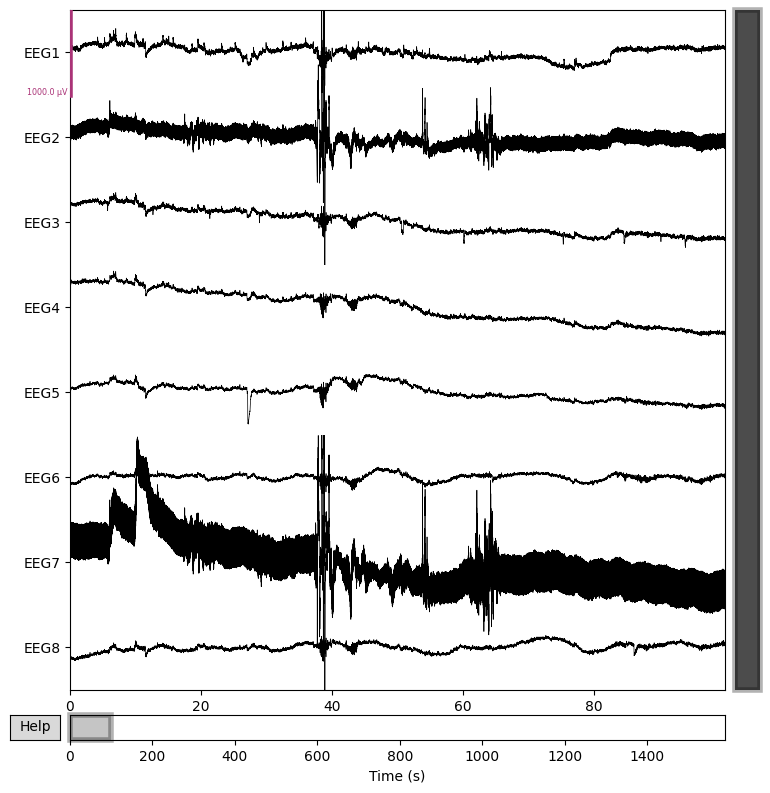

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\janni\AppData\Local\Temp\ipykernel_2996\1952587504.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig_psd = raw.plot_psd(fmin=0.1, fmax=120, show=True)
c:\Users\janni\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


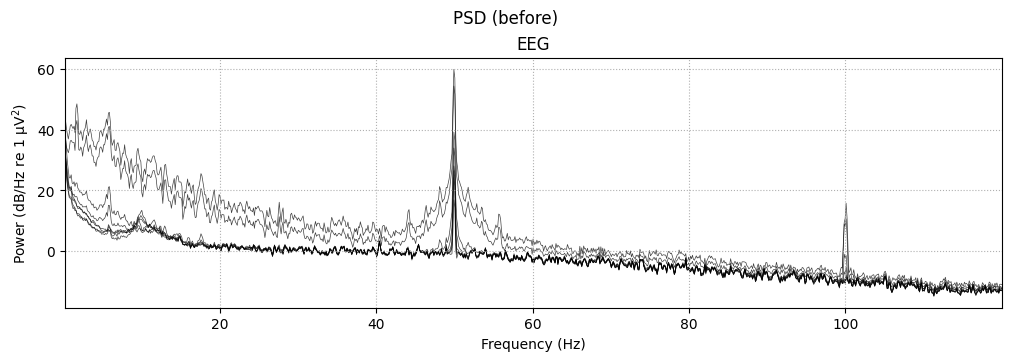

In [21]:
dur = min(100.0, raw.n_times / raw.info['sfreq'])
plot_raw_segment(raw, start_s=0.0, dur_s=dur, out_png=OUTDIR/"raw_before.png",
                 title=f"Raw (first {dur:.1f}s), before cleaning")

fig_psd = raw.plot_psd(fmin=0.1, fmax=120, show=True)
fig_psd.suptitle("PSD (before)")
fig_psd.savefig(OUTDIR/"psd_before.png", dpi=150)


In [24]:
# Build marker dataframe
markers_df = pd.DataFrame(columns=["time_stamp", "value"])

if marker_stream is not None:
    # marker values may be nested lists; time_series: list of lists/strings
    vals = marker_stream.get("time_series", [])
    vals = [v[0] if isinstance(v, (list, tuple)) else v for v in vals]
    stamps = marker_stream.get("time_stamps", [])
    markers_df = pd.DataFrame({"time_stamp": stamps, "value": vals})

# Align to EEG start (seconds from EEG t0)
t0 = float(eeg_stream["time_stamps"][0])
markers_df["onset_s"] = markers_df["time_stamp"] - t0

# Keep only meaningful onsets inside the recording
markers_df = markers_df[(markers_df["onset_s"] >= 0) & (markers_df["onset_s"] <= raw.n_times/raw.info["sfreq"])].copy()

# Extract trial onsets like "main_block_0_trial_12_on"
trial_pat = re.compile(r"main_block_(\d+)_trial_(\d+)_on")
def parse_trial(row):
    m = trial_pat.match(str(row["value"]))
    if m:
        return int(m.group(1)), int(m.group(2))
    return np.nan, np.nan

blk_trial = markers_df.apply(parse_trial, axis=1, result_type="expand")
markers_df["block"], markers_df["trial"] = blk_trial[0], blk_trial[1]
trials_df = markers_df.dropna(subset=["block", "trial"]).copy().reset_index(drop=True)

print(f"[INFO] Found {len(trials_df)} trial onsets")
display(trials_df.head(10))

# Save full tables
markers_csv = OUTDIR / "markers_all.csv"
trials_csv  = OUTDIR / "trials_extracted.csv"
markers_json = OUTDIR / "markers_all.json"
trials_json  = OUTDIR / "trials_extracted.json"

markers_df.to_csv(markers_csv, index=False)  # quotes are handled for the 'value' field with commas
trials_df.to_csv(trials_csv, index=False)

# JSON (nice if you prefer)
markers_df.to_json(markers_json, orient="records", indent=2)
trials_df.to_json(trials_json, orient="records", indent=2)

print("Saved:")
print(" -", markers_csv)
print(" -", trials_csv)
print(" -", markers_json)
print(" -", trials_json)


[INFO] Found 336 trial onsets


,time_stamp,value,onset_s,block,trial
0,333284.946777,main_block_0_trial_0_on,197.315052,0.0,0.0
1,333287.958031,main_block_0_trial_1_on,200.326305,0.0,1.0
2,333290.413273,main_block_0_trial_2_on,202.781547,0.0,2.0
3,333293.420636,main_block_0_trial_3_on,205.788911,0.0,3.0
4,333296.430351,main_block_0_trial_4_on,208.798626,0.0,4.0
5,333298.839185,main_block_0_trial_5_on,211.207459,0.0,5.0
6,333301.847515,main_block_0_trial_6_on,214.215790,0.0,6.0
7,333304.857799,main_block_0_trial_7_on,217.226074,0.0,7.0
8,333307.866744,main_block_0_trial_8_on,220.235019,0.0,8.0
9,333310.875160,main_block_0_trial_9_on,223.243435,0.0,9.0


Saved:
 - ..\data7eeg_out_nb\markers_all.csv
 - ..\data7eeg_out_nb\trials_extracted.csv
 - ..\data7eeg_out_nb\markers_all.json
 - ..\data7eeg_out_nb\trials_extracted.json


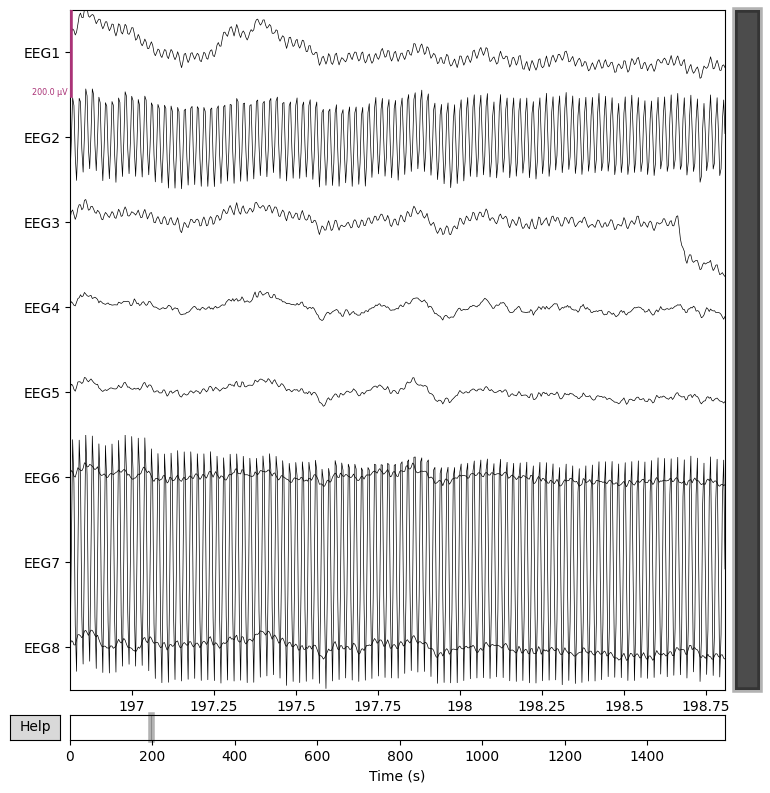

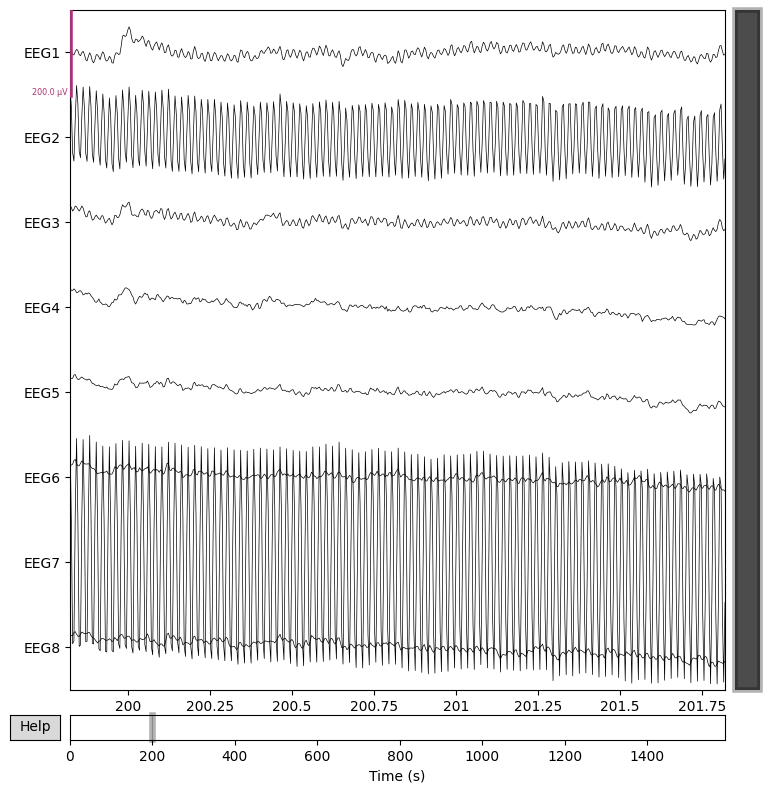

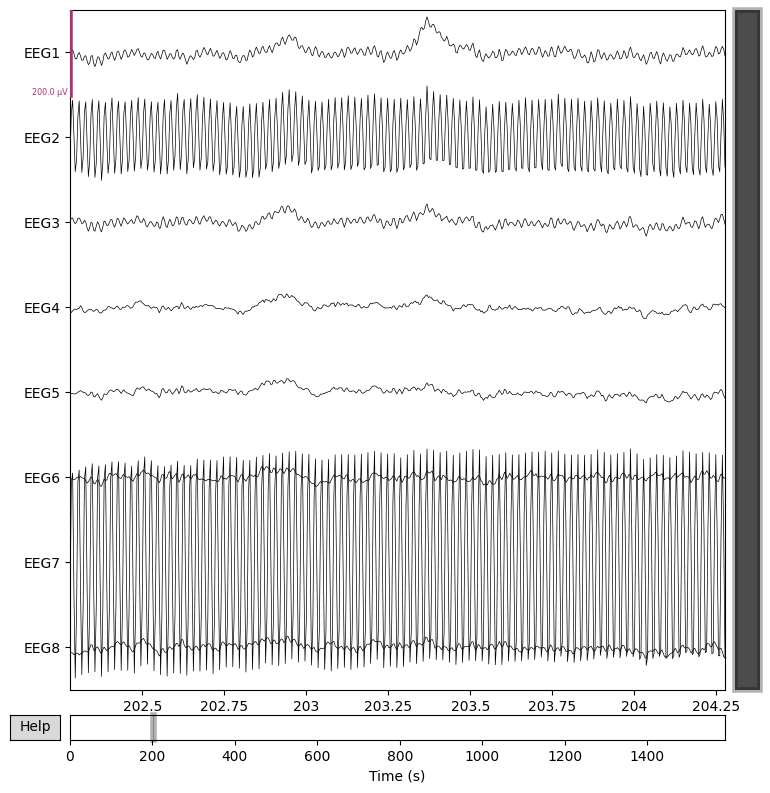

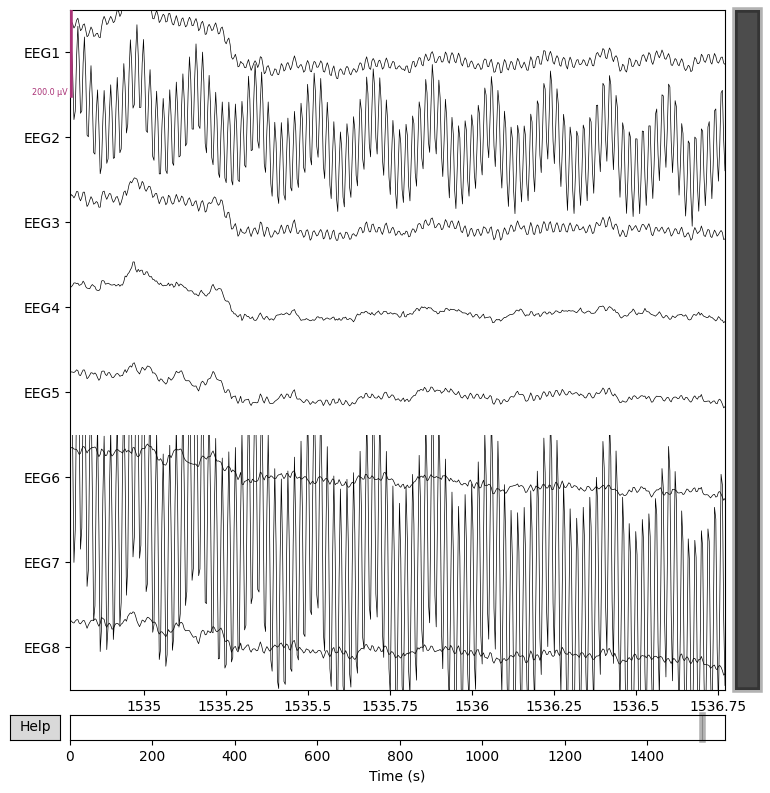

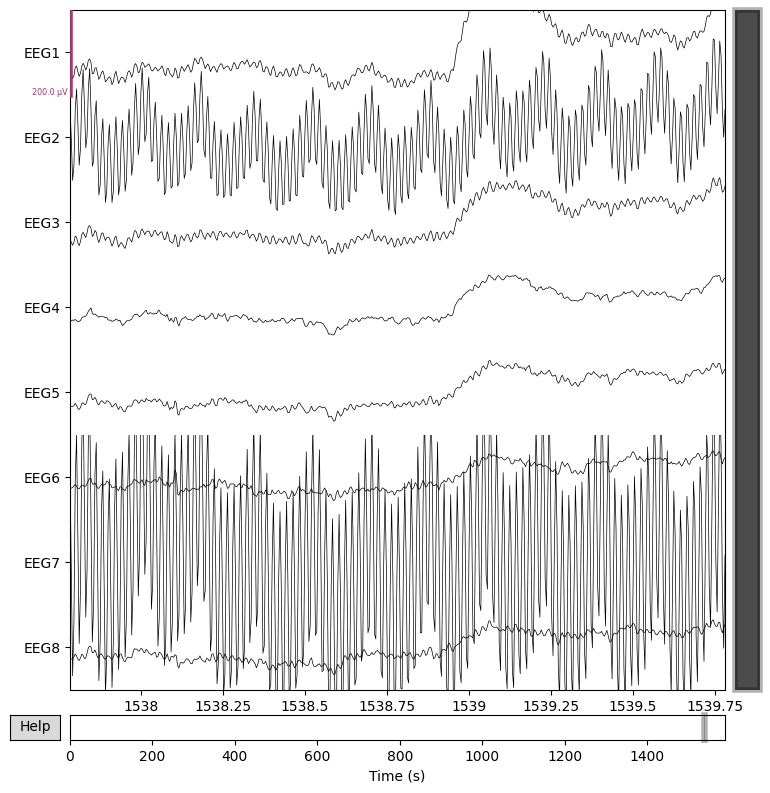

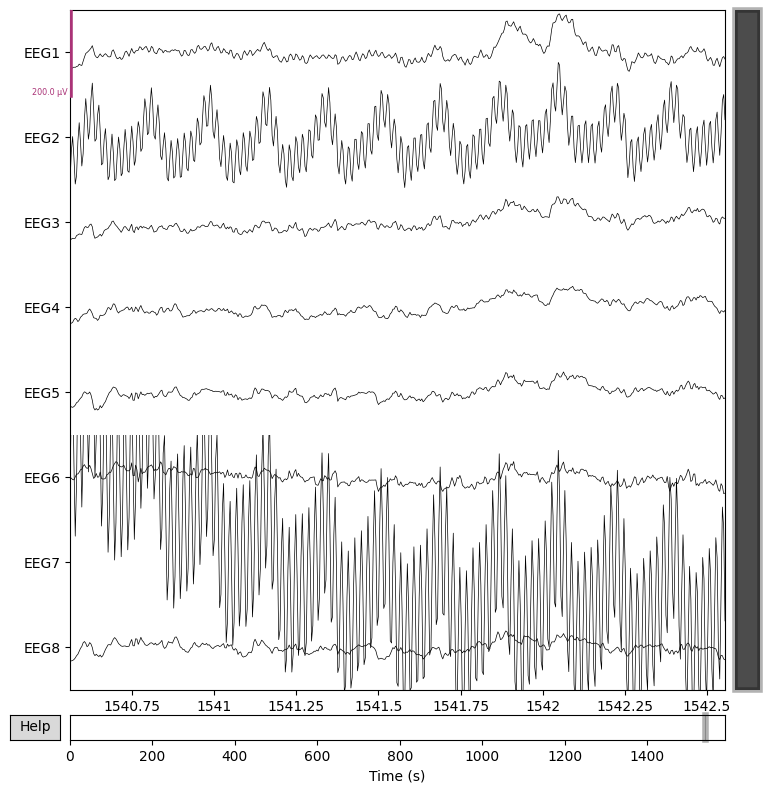

In [25]:
PLOT_UV = 100.0  # ±1000 µV


# Pick a few example trials to inspect
example_idx = list(trials_df.index[:3]) + list(trials_df.index[-3:])  # first 3 and last 3
example_idx = sorted(set([i for i in example_idx if 0 <= i < len(trials_df)]))

for i in example_idx:
    onset = float(trials_df.loc[i, "onset_s"])
    blk   = int(trials_df.loc[i, "block"])
    tri   = int(trials_df.loc[i, "trial"])
    start = max(0.0, onset - TRIAL_PRE)
    dur   = TRIAL_PRE + TRIAL_POST
    title = f"Trial window BEFORE cleaning | block={blk}, trial={tri}"
    plot_raw_segment(raw, start_s=start, dur_s=dur,
                     out_png=OUTDIR/f"trial_{i:04d}_before.png", title=title)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


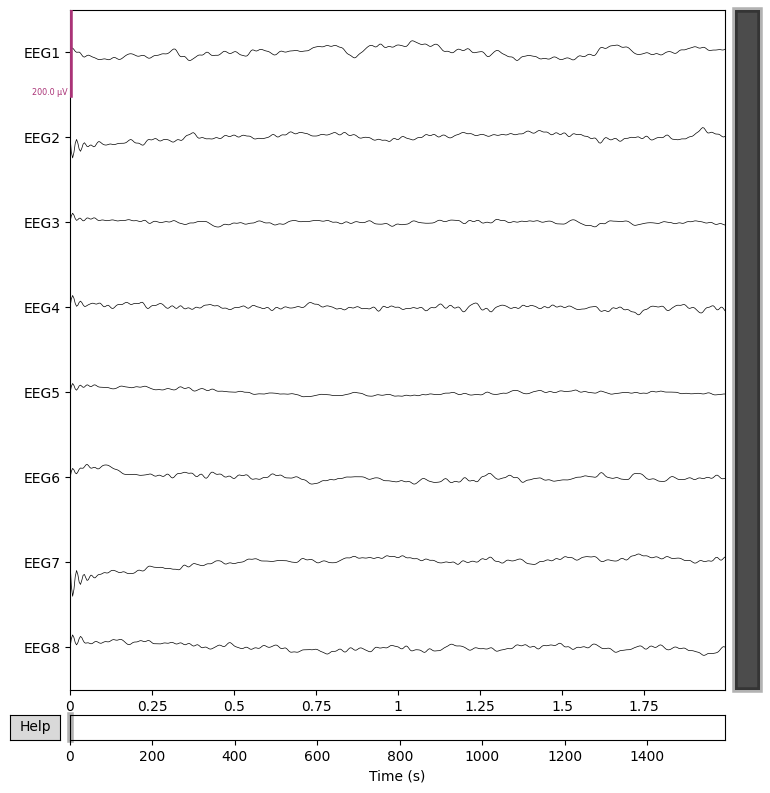

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\janni\AppData\Local\Temp\ipykernel_2996\3559350294.py:19: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig_psd2 = raw_clean.plot_psd(fmin=1, fmax=120, show=True)
c:\Users\janni\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Writing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\eeg_out_nb\raw_clean.fif


C:\Users\janni\AppData\Local\Temp\ipykernel_2996\3559350294.py:24: RuntimeWarning: This filename (c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\eeg_out_nb\raw_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(str(OUTDIR / "raw_clean.fif"), overwrite=True)


Closing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\eeg_out_nb\raw_clean.fif
[done]


[WindowsPath('c:/Users/janni/Documents/GitHub/eeg-brain-interface/notebooks/eeg_out_nb/raw_clean.fif')]

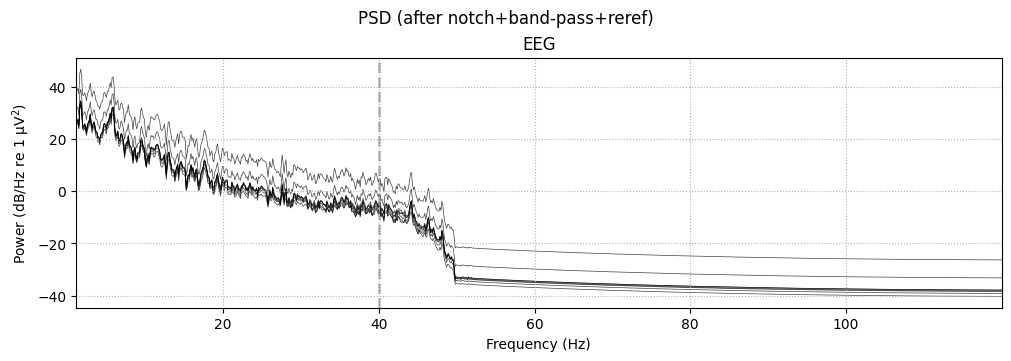

In [16]:
# Start from original 8-ch raw
raw_clean = raw.copy()

# Notch (mains + first harmonic)
raw_clean.notch_filter(freqs=[MAINS, 2*MAINS], picks="eeg", verbose="WARNING")

# Band-pass
l_freq, h_freq = BANDPASS
raw_clean.filter(l_freq=l_freq, h_freq=h_freq, picks="eeg",
                 method="fir", phase="zero", fir_window="hamming", verbose="WARNING")

# Average re-reference
raw_clean.set_eeg_reference("average")

# Quick global plots AFTER cleaning
plot_raw_segment(raw_clean, start_s=0.0, dur_s=dur, out_png=OUTDIR/"raw_after.png",
                 title=f"Raw (first {dur:.1f}s), after notch+bandpass+reref")

fig_psd2 = raw_clean.plot_psd(fmin=1, fmax=120, show=True)
fig_psd2.suptitle("PSD (after notch+band-pass+reref)")
fig_psd2.savefig(OUTDIR/"psd_after.png", dpi=150)

# Save cleaned raw
raw_clean.save(str(OUTDIR / "raw_clean.fif"), overwrite=True)


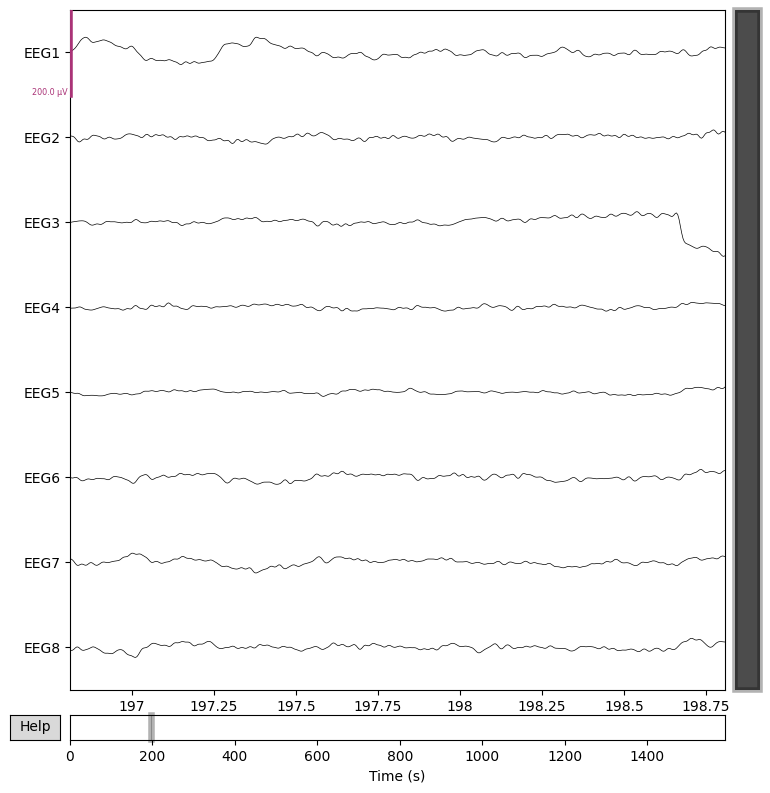

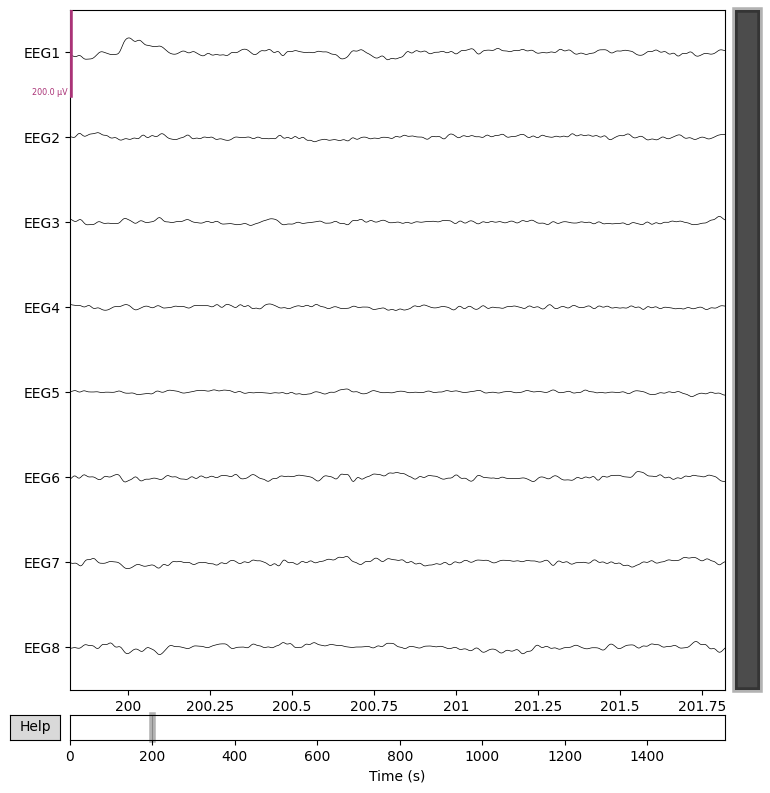

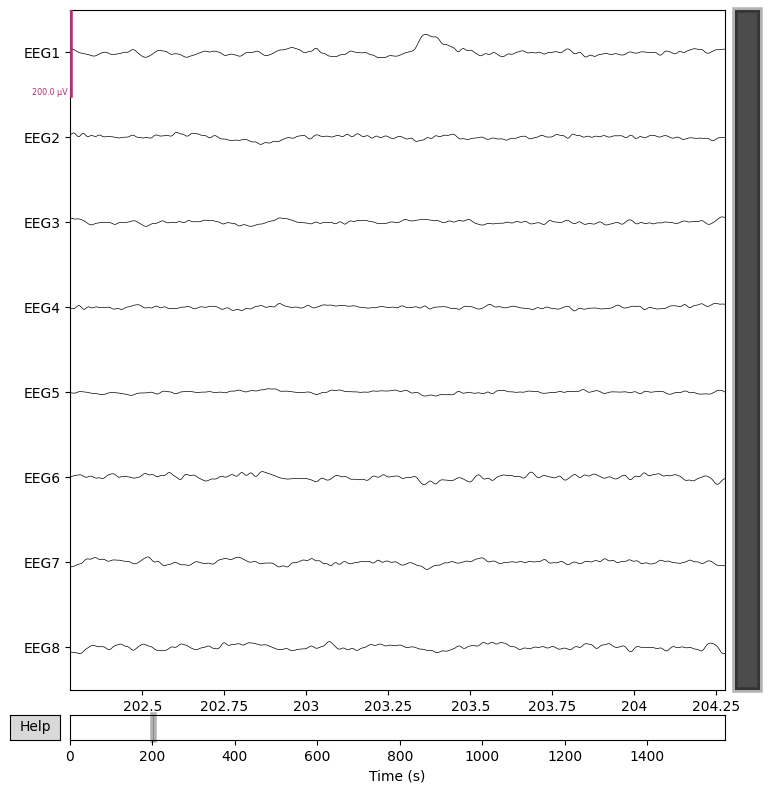

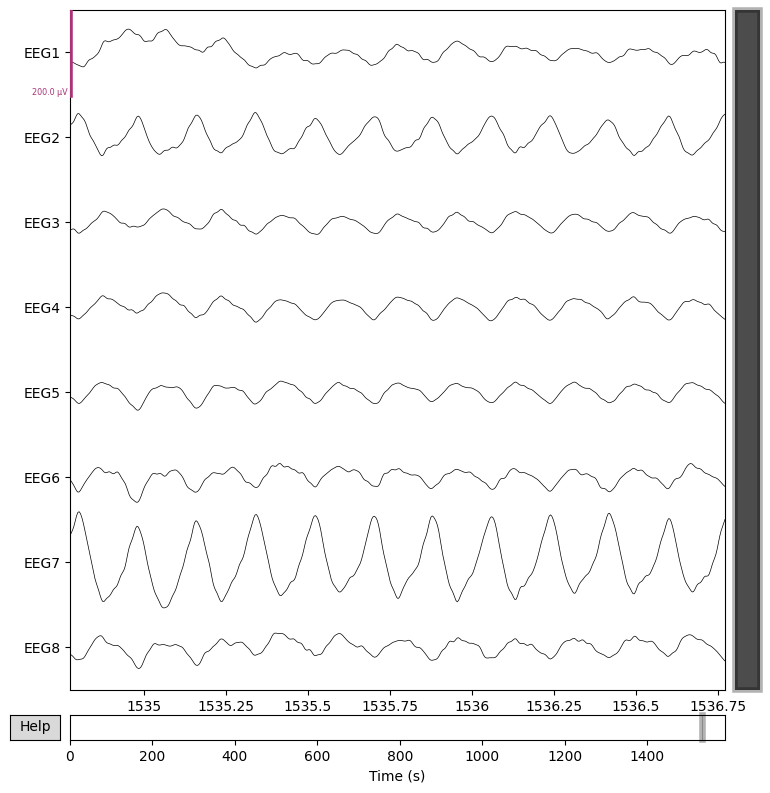

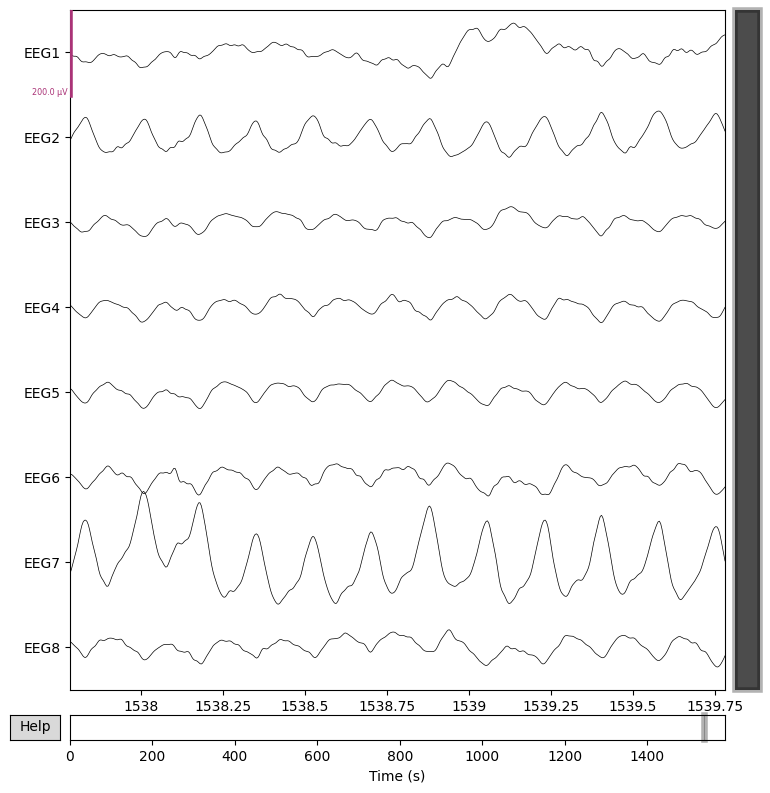

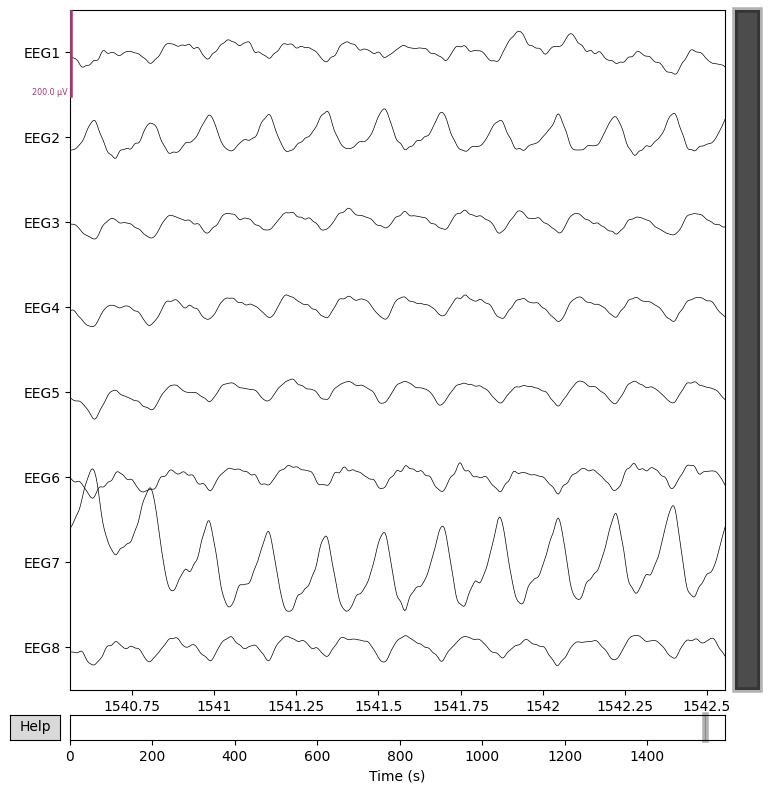

In [17]:
for i in example_idx:
    onset = float(trials_df.loc[i, "onset_s"])
    blk   = int(trials_df.loc[i, "block"])
    tri   = int(trials_df.loc[i, "trial"])
    start = max(0.0, onset - TRIAL_PRE)
    dur   = TRIAL_PRE + TRIAL_POST
    title = f"Trial window AFTER cleaning | block={blk}, trial={tri}"
    plot_raw_segment(raw_clean, start_s=start, dur_s=dur,
                     out_png=OUTDIR/f"trial_{i:04d}_after.png", title=title)


In [27]:
import re
import numpy as np
import pandas as pd
import mne

# ---------- Build markers_df (values + onsets in seconds from EEG start) ----------
markers_df = pd.DataFrame(columns=["time_stamp", "value", "onset_s"])
if marker_stream is None:
    print("[WARN] No marker stream found; skipping difficulty inference.")
else:
    vals = marker_stream.get("time_series", [])
    vals = [v[0] if isinstance(v, (list, tuple)) else v for v in vals]
    stamps = np.asarray(marker_stream.get("time_stamps", []), dtype=float)
    # align to EEG t0
    t0 = float(eeg_stream["time_stamps"][0])
    onsets = stamps - t0
    markers_df = pd.DataFrame({"time_stamp": stamps, "value": vals, "onset_s": onsets})
    # keep only markers that fall inside this Raw
    rec_dur = raw.n_times / raw.info["sfreq"]
    markers_df = markers_df[(markers_df["onset_s"] >= 0) & (markers_df["onset_s"] <= rec_dur)].copy()
    markers_df.sort_values("onset_s", inplace=True, ignore_index=True)

# ---------- Parse per-block: start time, sequence letters, targets list ----------
block_info = {}  # block_id -> dict(start, seq, targets)
current_block = None

for _, row in markers_df.iterrows():
    val = str(row["value"])
    t   = float(row["onset_s"])

    m_start = re.match(r"main_block_(\d+)_start", val)
    if m_start:
        current_block = int(m_start.group(1))
        block_info.setdefault(current_block, {})["start"] = t
        continue

    # sequence_<letters comma-separated>
    if val.startswith("sequence_"):
        seq_str = val.split("sequence_", 1)[1]
        letters = [s.strip() for s in seq_str.split(",") if s.strip()]
        if current_block is not None:
            block_info.setdefault(current_block, {})["seq"] = letters
        continue

    # targets_<comma-separated indices> (usually 1-based integers)
    if val.startswith("targets_"):
        targ_str = val.split("targets_", 1)[1]
        try:
            targets = [int(x.strip()) for x in targ_str.split(",") if x.strip().isdigit()]
        except Exception:
            targets = []
        if current_block is not None:
            block_info.setdefault(current_block, {})["targets"] = targets
        continue

# determine block end as next block's start (or recording end)
sorted_blocks = sorted(block_info.keys())
for i, b in enumerate(sorted_blocks):
    start = block_info[b].get("start", 0.0)
    end = rec_dur
    if i + 1 < len(sorted_blocks):
        nxt = sorted_blocks[i + 1]
        end = block_info[nxt].get("start", rec_dur)
    block_info[b]["end"] = float(end)
    block_info[b]["dur"] = max(0.0, float(end) - float(start))

# ---------- Infer n-back by comparing predicted targets for n=1..3 ----------
def infer_nback(seq_letters, given_targets, max_n=3):
    given = set(given_targets or [])
    scores = []
    for n in range(1, max_n + 1):
        pred = []
        for i in range(n, len(seq_letters)):
            if seq_letters[i] == seq_letters[i - n]:
                pred.append(i + 1)  # 1-based index like your markers
        pred_set = set(pred)
        # score: smaller symmetric difference is better (perfect match => 0)
        diff = len(pred_set ^ given)
        overlap = len(pred_set & given)
        scores.append((n, diff, overlap, pred))
    # choose n with minimal diff; tie-break by larger overlap, then smaller n
    scores.sort(key=lambda x: (x[1], -x[2], x[0]))
    best_n, best_diff, best_overlap, best_pred = scores[0]
    return best_n, {"diff": best_diff, "overlap": best_overlap, "pred": best_pred}

for b in sorted_blocks:
    seq = block_info[b].get("seq", [])
    tgs = block_info[b].get("targets", [])
    if seq and tgs:
        n, info = infer_nback(seq, tgs, max_n=3)
        block_info[b]["nback"] = int(n)
        block_info[b]["match_info"] = info
    else:
        block_info[b]["nback"] = None

# quick printout
for b in sorted_blocks:
    print(f"[BLOCK {b}] start={block_info[b]['start']:.2f}s dur={block_info[b]['dur']:.2f}s "
          f"nback={block_info[b].get('nback')} "
          f"(seq={len(block_info[b].get('seq', []))} letters, "
          f"targets={len(block_info[b].get('targets', []))})")

# ---------- Add MNE Annotations with inferred difficulty ----------
ann_onsets, ann_durs, ann_descs = [], [], []
for b in sorted_blocks:
    nb = block_info[b].get("nback")
    if nb is None:
        continue
    start = float(block_info[b]["start"])
    dur   = float(block_info[b]["dur"])
    if dur <= 0:
        continue
    desc = f"nback_{nb}_block_{b}"
    ann_onsets.append(start)
    ann_durs.append(dur)
    ann_descs.append(desc)

if ann_onsets:
    anns = mne.Annotations(onset=ann_onsets, duration=ann_durs, description=ann_descs, orig_time=None)
    # attach to Raw so it's saved into the FIF
    raw.set_annotations(raw.annotations + anns if len(raw.annotations) else anns)
    print(f"[INFO] Added {len(anns)} block annotations with inferred n-back.")

    # (optional) also save a CSV for your records
    out_csv = OUTDIR / "blocks_inferred_nback.csv"
    rows = []
    for b in sorted_blocks:
        rows.append({
            "block": b,
            "start_s": block_info[b].get("start", np.nan),
            "end_s":   block_info[b].get("end",   np.nan),
            "nback":   block_info[b].get("nback", None),
            "n_seq":   len(block_info[b].get("seq", [])),
            "n_targets": len(block_info[b].get("targets", [])),
        })
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print("[OK] Saved:", out_csv)
else:
    print("[WARN] No annotations created (no blocks with inferred n-back).")


[BLOCK 0] start=197.31s dur=151.28s nback=2 (seq=48 letters, targets=16)
[BLOCK 1] start=348.59s dur=214.82s nback=2 (seq=48 letters, targets=15)
[BLOCK 2] start=563.42s dur=210.18s nback=3 (seq=48 letters, targets=15)
[BLOCK 3] start=773.60s dur=211.00s nback=1 (seq=48 letters, targets=15)
[BLOCK 4] start=984.60s dur=211.75s nback=3 (seq=48 letters, targets=15)
[BLOCK 5] start=1196.34s dur=209.59s nback=3 (seq=48 letters, targets=15)
[BLOCK 6] start=1405.93s dur=183.44s nback=2 (seq=48 letters, targets=15)
[INFO] Added 7 block annotations with inferred n-back.
[OK] Saved: ..\data7eeg_out_nb\blocks_inferred_nback.csv


In [28]:
raw.save(str(OUTDIR / "raw_initial_eeg_with_blocks.fif"), overwrite=True)
print("[OK] Saved FIF with block annotations.")


Writing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_initial_eeg_with_blocks.fif


C:\Users\janni\AppData\Local\Temp\ipykernel_2996\4178392314.py:1: RuntimeWarning: This filename (c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_initial_eeg_with_blocks.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(OUTDIR / "raw_initial_eeg_with_blocks.fif"), overwrite=True)


Closing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_initial_eeg_with_blocks.fif
[done]
[OK] Saved FIF with block annotations.


<Annotations | 7 segments: nback_1_block_3 (1), nback_2_block_0 (1), ...>


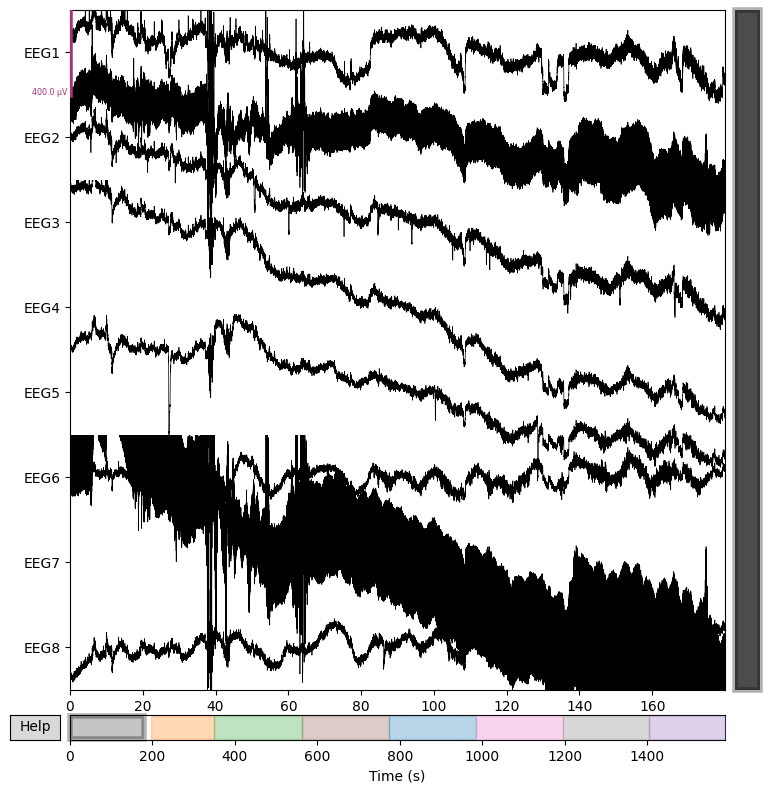

Text(0.5, 0.98, 'EEG with inferred n-back block annotations')

In [30]:
import matplotlib.pyplot as plt

# Quick check
print(raw.annotations)

# Plot a 60 s window to see blocks with annotation bars
fig = raw.plot(start=0, duration=180,
               scalings={'eeg': 200e-6},   # 200 µV range
               show_options=False,
               show_first_samp=False,
               decim=1)

fig.suptitle("EEG with inferred n-back block annotations", fontsize=14)


In [41]:
import re
import numpy as np
import pandas as pd
import mne

# --- Build markers_df aligned to EEG time (seconds from EEG start) ---
markers_df = pd.DataFrame(columns=["time_stamp", "value", "onset_s"])

if marker_stream is None:
    print("[WARN] No marker stream found; continuing without markers.")
else:
    vals = marker_stream.get("time_series", [])
    vals = [v[0] if isinstance(v, (list, tuple)) else v for v in vals]
    stamps = np.asarray(marker_stream.get("time_stamps", []), dtype=float)
    t0 = float(eeg_stream["time_stamps"][0])
    onsets = stamps - t0
    rec_dur = float(raw.n_times / raw.info["sfreq"])

    markers_df = pd.DataFrame({"time_stamp": stamps, "value": vals, "onset_s": onsets})
    markers_df = markers_df[(markers_df["onset_s"] >= 0) & (markers_df["onset_s"] <= rec_dur)].copy()
    markers_df.sort_values("onset_s", inplace=True, ignore_index=True)

# --- Parse per-block starts, sequences, targets ---
block_info = {}  # block_id -> dict(start, end, dur, seq, targets)
current_block = None

for _, row in markers_df.iterrows():
    val = str(row["value"])
    t   = float(row["onset_s"])

    m_start = re.match(r"main_block_(\d+)_start", val)
    if m_start:
        current_block = int(m_start.group(1))
        block_info.setdefault(current_block, {})["start"] = t
        continue

    if val.startswith("sequence_"):
        seq = [s.strip() for s in val.split("sequence_", 1)[1].split(",") if s.strip()]
        if current_block is not None:
            block_info.setdefault(current_block, {})["seq"] = seq
        continue

    if val.startswith("targets_"):
        parts = [p.strip() for p in val.split("targets_", 1)[1].split(",") if p.strip()]
        tgts = [int(p) for p in parts if p.isdigit()]
        if current_block is not None:
            block_info.setdefault(current_block, {})["targets"] = tgts
        continue

# close block ends using next block start / recording end
rec_dur = float(raw.n_times / raw.info["sfreq"])
sorted_blocks = sorted(block_info.keys())
for i, b in enumerate(sorted_blocks):
    start = float(block_info[b].get("start", 0.0))
    end = rec_dur if i+1 == len(sorted_blocks) else float(block_info[sorted_blocks[i+1]].get("start", rec_dur))
    block_info[b]["end"] = end
    block_info[b]["dur"] = max(0.0, end - start)

# --- Parse trial onsets for a trial table ---
trial_pat = re.compile(r"main_block_(\d+)_trial_(\d+)_on")
def parse_trial_row(val):
    m = trial_pat.match(str(val))
    if m:
        return int(m.group(1)), int(m.group(2))
    return np.nan, np.nan

bt = markers_df["value"].apply(parse_trial_row)
markers_df["block"] = bt.apply(lambda x: x[0])
markers_df["trial"] = bt.apply(lambda x: x[1])

trials_df = markers_df.dropna(subset=["block", "trial"]).copy()
trials_df["block"] = trials_df["block"].astype(int)
trials_df["trial"] = trials_df["trial"].astype(int)

print(f"[INFO] Blocks found: {sorted_blocks}")
print(f"[INFO] Trials found: {len(trials_df)}")


[INFO] Blocks found: [0, 1, 2, 3, 4, 5, 6]
[INFO] Trials found: 336


In [42]:
# ===== MANUAL DIFFICULTY MAP =====
# Set exactly what you want: block_id -> difficulty (0,1,2,3)
difficulty_map = {
    0: 0, 1: 3, 2: 1, 3: 2, 4: 2, 5: 1, 6: 3}

# Attach difficulty to block_info (manual overrides)
for b, nb in difficulty_map.items():
    if b in block_info:
        block_info[b]["nback"] = int(nb)
    else:
        print(f"[WARN] block {b} not found in block_info; ignoring mapping entry")

# Build block annotation lists
ann_onsets, ann_durs, ann_descs = [], [], []
for b in sorted_blocks:
    nb  = block_info[b].get("nback", None)
    st  = float(block_info[b].get("start", 0.0))
    dur = float(block_info[b].get("dur", 0.0))
    if nb is None or dur <= 0:
        continue
    ann_onsets.append(st)
    ann_durs.append(dur)
    ann_descs.append(f"nback_{int(nb)}_block_{int(b)}")

# Replace any existing nback_* block annotations with the new set
old = raw.annotations
keep_idx = [i for i, desc in enumerate(old.description) if not re.match(r"^nback_\d+_block_\d+$", desc)]
base_onsets = [old.onset[i] for i in keep_idx]
base_durs   = [old.duration[i] for i in keep_idx]
base_descs  = [old.description[i] for i in keep_idx]

base_onsets += ann_onsets
base_durs   += ann_durs
base_descs  += ann_descs

new_anns = mne.Annotations(onset=base_onsets, duration=base_durs, description=base_descs, orig_time=None)
raw.set_annotations(new_anns)
print(f"[OK] Added {len(ann_onsets)} block annotations with MANUAL difficulties.")

# Save a neat annotations table with parsed columns
ann_df = raw.annotations.to_data_frame()
parsed = ann_df["description"].str.extract(r"^nback_(\d+)_block_(\d+)$")
ann_df["nback"] = pd.to_numeric(parsed[0], errors="coerce").astype("Int64")
ann_df["block"] = pd.to_numeric(parsed[1], errors="coerce").astype("Int64")
ann_df_path = OUTDIR / "annotations_with_manual_difficulty.csv"
ann_df.to_csv(ann_df_path, index=False)
print("[OK] Saved:", ann_df_path)

# Save FIF so the annotations live with the EEG
raw_with_blocks_fif = OUTDIR / "raw_with_manual_blocks.fif"
raw.save(str(raw_with_blocks_fif), overwrite=True)
print("[OK] Saved FIF:", raw_with_blocks_fif)


[OK] Added 7 block annotations with MANUAL difficulties.
[OK] Saved: ..\data7eeg_out_nb\annotations_with_manual_difficulty.csv
Writing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_with_manual_blocks.fif


C:\Users\janni\AppData\Local\Temp\ipykernel_2996\3610734616.py:51: RuntimeWarning: This filename (c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_with_manual_blocks.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(raw_with_blocks_fif), overwrite=True)


Closing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_with_manual_blocks.fif
[done]
[OK] Saved FIF: ..\data7eeg_out_nb\raw_with_manual_blocks.fif


In [43]:
# Join trial rows with block difficulties
block_to_nback = {b: block_info[b].get("nback", None) for b in sorted_blocks}
trials_df["nback"] = trials_df["block"].map(block_to_nback)

# (Optional) add short annotations at each trial onset with difficulty
trial_ann_on, trial_ann_du, trial_ann_desc = [], [], []
for _, r in trials_df.iterrows():
    if pd.isna(r["nback"]):  # block without assigned difficulty
        continue
    t = float(r["onset_s"])
    trial_ann_on.append(t)
    trial_ann_du.append(0.001)  # very short tick-like annotation
    trial_ann_desc.append(f"trial_b{int(r['block'])}_#{int(r['trial'])}_n{int(r['nback'])}")

if trial_ann_on:
    trial_anns = mne.Annotations(onset=trial_ann_on, duration=trial_ann_du, description=trial_ann_desc, orig_time=None)
    raw.set_annotations(raw.annotations + trial_anns)
    print(f"[OK] Added {len(trial_ann_on)} trial annotations (ticks with difficulty).")

# Save linked trials table
trials_out = OUTDIR / "trials_with_difficulty.csv"
trials_df.to_csv(trials_out, index=False)
print("[OK] Saved:", trials_out)

# (Re)save FIF with both block + trial annotations
raw_with_trials_fif = OUTDIR / "raw_with_manual_blocks_and_trials.fif"
raw.save(str(raw_with_trials_fif), overwrite=True)
print("[OK] Saved FIF:", raw_with_trials_fif)


[OK] Added 336 trial annotations (ticks with difficulty).
[OK] Saved: ..\data7eeg_out_nb\trials_with_difficulty.csv
Writing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_with_manual_blocks_and_trials.fif


C:\Users\janni\AppData\Local\Temp\ipykernel_2996\1413918055.py:27: RuntimeWarning: This filename (c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_with_manual_blocks_and_trials.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(raw_with_trials_fif), overwrite=True)


Closing c:\Users\janni\Documents\GitHub\eeg-brain-interface\notebooks\..\data7eeg_out_nb\raw_with_manual_blocks_and_trials.fif
[done]
[OK] Saved FIF: ..\data7eeg_out_nb\raw_with_manual_blocks_and_trials.fif


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Remaining channels: ['EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8']
Block 0: nback=0 | dur=151.3s
Block 1: nback=3 | dur=214.8s
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


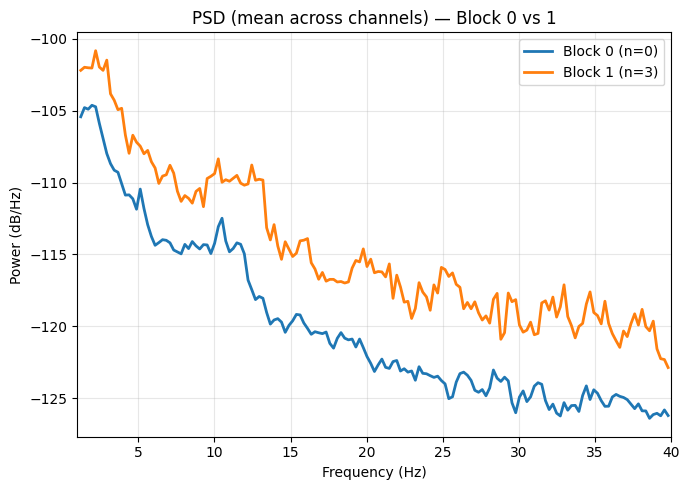

Saved: ..\data7eeg_out_nb\block_0_clean_140s.png ..\data7eeg_out_nb\block_1_clean_140s.png ..\data7eeg_out_nb\psd_block_0_vs_1.png


In [57]:
# ==== params: pick the two blocks and filter settings ====
block_a, block_b = 0, 1     # << change which blocks to compare
MAINS = 50                  # 50 (EU) or 60 (US)
BAND = (2, 45.0)          # band-pass range (Hz)
PLOT_UV = 200.0             # raw plot vertical scale in µV
SHOW_DUR = 140.0             # seconds to show from each block

import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch

# --- 1) Cleaned copy: notch -> band-pass -> average re-reference ---
raw_proc = raw.copy()
raw_proc.notch_filter(freqs=[MAINS, 2*MAINS], picks='eeg', verbose='WARNING')
raw_proc.filter(l_freq=BAND[0], h_freq=BAND[1], picks='eeg',
                method='fir', phase='zero', fir_window='hamming', verbose='WARNING')
#raw_proc.set_eeg_reference('average')

#keep_chs = ["EEG1", "EEG2", "EEG3", "EEG4"]
keep_chs = ["EEG1", "EEG2", "EEG3", "EEG4", "EEG5", "EEG6", "EEG7", "EEG8"]

raw_proc_sub = raw_proc.copy().pick_channels([ch for ch in keep_chs if ch in raw_proc.ch_names])
print("Remaining channels:", raw_proc_sub.ch_names)

# --- 2) Crop to blocks ---
def crop_block(r, b):
    if b not in block_info:
        raise KeyError(f"Block {b} not in block_info")
    st = float(block_info[b]["start"])
    dur = float(block_info[b]["dur"])
    return r.copy().crop(tmin=st, tmax=st+dur, include_tmax=False)

raw_a = crop_block(raw_proc_sub, block_a)
raw_b = crop_block(raw_proc_sub, block_b)


print(f"Block {block_a}: nback={block_info[block_a].get('nback')} | dur={block_info[block_a]['dur']:.1f}s")
print(f"Block {block_b}: nback={block_info[block_b].get('nback')} | dur={block_info[block_b]['dur']:.1f}s")

# --- 3) Plot: first 10 s from each block (saved pngs) ---
dur_a = min(SHOW_DUR, raw_a.n_times/raw_a.info['sfreq'])
dur_b = min(SHOW_DUR, raw_b.n_times/raw_b.info['sfreq'])


# --- 4) PSD overlay (mean across channels) for the two blocks ---
def avg_psd_db(raw_obj, fmin=1.0, fmax=40.0):
    X = raw_obj.get_data()                  # (n_ch, n_times) in Volts
    fs = float(raw_obj.info['sfreq'])
    nperseg = min(1024, X.shape[1])
    noverlap = min(512, max(0, nperseg - 1))
    psds, freqs = psd_array_welch(
        X, sfreq=fs, fmin=fmin, fmax=fmax,
        n_fft=nperseg, n_overlap=noverlap, n_per_seg=nperseg, average='mean'
    )  # psds: (n_ch, n_freqs) in V^2/Hz
    psd_db = 10*np.log10(np.maximum(psds, 1e-20))  # dB/Hz
    return freqs, psd_db.mean(axis=0)

fmin, fmax = 1.0, 40.0
fa, Pa = avg_psd_db(raw_a, fmin, fmax)
fb, Pb = avg_psd_db(raw_b, fmin, fmax)

plt.figure(figsize=(7,5))
plt.plot(fa, Pa, label=f"Block {block_a} (n={block_info[block_a].get('nback')})", lw=2)
plt.plot(fb, Pb, label=f"Block {block_b} (n={block_info[block_b].get('nback')})", lw=2)
plt.xlim(fmin, fmax)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB/Hz)")
plt.title(f"PSD (mean across channels) — Block {block_a} vs {block_b}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUTDIR / f"psd_block_{block_a}_vs_{block_b}.png", dpi=150)
plt.show()

print("Saved:",
      OUTDIR / f"block_{block_a}_clean_{int(dur_a)}s.png",
      OUTDIR / f"block_{block_b}_clean_{int(dur_b)}s.png",
      OUTDIR / f"psd_block_{block_a}_vs_{block_b}.png")
